In [1]:
import pandas as pd
from textblob import TextBlob
import csv
from gutenberg.acquire import load_etext
from gutenberg.cleanup import strip_headers
import os
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

In [3]:
n = 55
t = 'wizard'
s = 32

In [69]:
df_novel = pd.read_csv('data/novel_' + 'wizard' + '3.csv', index_col=False) 

In [13]:
df_novel.head()

,0,wrd_length,char_length
0,The Wonderful Wizard of Oz by...,"[3, 9, 6, 2, 2, 2, 1, 5, 4, 8, 12, 1]",55
1,The Cyclone 2.,"[3, 7, 1]",11
2,The Council with the Munchkins 3.,"[3, 7, 4, 3, 9, 1]",27
3,How Dorothy Saved the Scarecrow 4.,"[3, 7, 5, 3, 9, 1]",28
4,The Road Through the Forest 5.,"[3, 4, 7, 3, 6, 1]",24


In [14]:
def CountSyllables(word, isName=True):
    vowels = "aeiouy"
    #single syllables in words like bread and lead, but split in names like Breanne and Adreann
    specials = ["ia","ea"] if isName else ["ia"]
    specials_except_end = ["ie","ya","es","ed"]  #seperate syllables unless ending the word
    currentWord = word.lower()
    numVowels = 0
    lastWasVowel = False
    last_letter = ""

    for letter in currentWord:
        if letter in vowels:
            #don't count diphthongs unless special cases
            combo = last_letter+letter
            if lastWasVowel and combo not in specials and combo not in specials_except_end:
                lastWasVowel = True
            else:
                numVowels += 1
                lastWasVowel = True
        else:
            lastWasVowel = False

        last_letter = letter

    #remove es & ed which are usually silent
    if len(currentWord) > 2 and currentWord[-2:] in specials_except_end:
        numVowels -= 1

    #remove silent single e, but not ee since it counted it before and we should be correct
    elif len(currentWord) > 2 and currentWord[-1:] == "e" and currentWord[-2:] != "ee" and currentWord != 'the':
        numVowels -= 1

    return numVowels

In [70]:
syl = []
for l in df_novel['0']:
    sent = TextBlob(l)
    syl_single = []
    for x in sent.words:
        m = CountSyllables(x)
        syl_single.append(m)
    syl.append(syl_single)   

In [71]:
syl_count_arr = []
for n in syl:
    n = np.array(n)
    syl_count_arr.append(n)

In [72]:
df_novel['syl_count'] = syl_count_arr

In [82]:
df_novel.head()

,0,wrd_length,char_length,syl_count,syl_sum,sentiment,syl_ratio
0,The Wonderful Wizard of Oz by...,"[3, 9, 6, 2, 2, 2, 1, 5, 4, 8, 12, 1]",55,"[1, 3, 2, 1, 1, 1, 0, 1, 1, 2, 4, 0]",17,1.0,0.309091
1,The Cyclone 2.,"[3, 7, 1]",11,"[1, 2, 0]",3,0.0,0.272727
2,The Council with the Munchkins 3.,"[3, 7, 4, 3, 9, 1]",27,"[1, 2, 1, 1, 2, 0]",7,0.0,0.259259
3,How Dorothy Saved the Scarecrow 4.,"[3, 7, 5, 3, 9, 1]",28,"[1, 3, 1, 1, 3, 0]",9,0.0,0.321429
4,The Road Through the Forest 5.,"[3, 4, 7, 3, 6, 1]",24,"[1, 1, 1, 1, 2, 0]",6,0.0,0.250000


In [74]:
syl_sum = []
for l in range(0,len(df_novel)):
    syl_sum.append(df_novel['syl_count'][l].sum())

In [75]:
df_novel['syl_sum'] = syl_sum

In [77]:
def detect_sentiment(text):
    return TextBlob(text.decode('utf-8')).sentiment.polarity

In [78]:
df_novel['sentiment'] = df_novel['0'].apply(detect_sentiment)

In [80]:
df_novel['syl_ratio'] = df_novel['syl_sum']/df_novel['char_length']

In [81]:
df2 = df_novel[df_novel['char_length'] > 2]

In [83]:
df2 = df2.drop('wrd_length', 1)


In [84]:
df2 = df2.drop('syl_count', 1)

In [85]:
X = df2

In [88]:
X = df2.drop('0', axis=1)

In [92]:
df2.tail()

,0,char_length,syl_sum,sentiment,syl_ratio
2266,"""Where in the world did you come from?""",29,8,0.000,0.275862
2267,"""From the Land of Oz,"" said Dorothy gravely.",33,12,0.000,0.363636
2268,"""And here is Toto, too.",16,6,0.000,0.375000
2269,"And oh, Aunt Em!",11,4,0.000,0.363636
2270,"I'm so glad to be at home again!""",24,9,0.625,0.375000


In [54]:
X.tail()

,0,char_length,syl_sum,sentiment,syl_ratio
2266,"""Where in the world did you come from?""",29,8,0.000,0.275862
2267,"""From the Land of Oz,"" said Dorothy gravely.",33,12,0.000,0.363636
2268,"""And here is Toto, too.",16,6,0.000,0.375000
2269,"And oh, Aunt Em!",11,4,0.000,0.363636
2270,"I'm so glad to be at home again!""",24,9,0.625,0.375000


In [89]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, random_state=1)
km.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [90]:
km.labels_

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [95]:
df2['cluster'] = km.labels_
df2.sort_values('cluster')

,0,char_length,syl_sum,sentiment,syl_ratio,cluster
673,Dorothy thought she would go next; so she took...,109,30,-5.952381e-02,0.275229,0
1700,"""I shall really be very unhappy unless you giv...",84,30,-6.900000e-01,0.357143,0
1698,The True courage is in facing danger when you ...,81,25,1.166667e-01,0.308642,0
811,"But the Scarecrow and the Tin Woodman, not bei...",87,25,2.500000e-01,0.287356,0
812,"""Run fast,"" said the Scarecrow to the Lion, ""a...",76,25,0.000000e+00,0.328947,0
813,"We will bring the little girl with us, but if ...",77,23,-9.375000e-02,0.298701,0
818,"On and on they walked, and it seemed that the ...",92,28,3.000000e-01,0.304348,0
819,"They followed the bend of the river, and at la...",94,29,1.000000e-01,0.308511,0
821,"""We can do nothing for him,"" said the Tin Wood...",67,24,-1.666667e-01,0.358209,0
822,"We must leave him here to sleep on forever, an...",82,27,0.000000e+00,0.329268,0


In [93]:
km.cluster_centers_

array([[  8.87186441e+01,   2.77841808e+01,   1.12368623e-01,
          3.13729351e-01],
       [  3.17988722e+01,   1.00291353e+01,   4.67254898e-02,
          3.13798529e-01],
       [  1.56956229e+02,   4.83973064e+01,   1.32724832e-01,
          3.08807648e-01]])

In [96]:
df2.groupby('cluster').mean()

,char_length,syl_sum,sentiment,syl_ratio
cluster,,,,
0,88.680995,27.769231,0.112383,0.313704
1,31.798872,10.029135,0.046725,0.313799
2,156.838926,48.372483,0.132615,0.308899


In [97]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [98]:
km = KMeans(n_clusters=3, random_state=1)
km.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [100]:
# save the cluster labels and sort by cluster
df2['cluster'] = km.labels_
#beer.sort_values('cluster')
df2.sort_values('sentiment')

,0,char_length,syl_sum,sentiment,syl_ratio,cluster
1260,When the Wicked Witch looked out again and saw...,121,35,-1.000000,0.289256,2
1908,"The Scarecrow was thinking again, and his head...",86,28,-1.000000,0.325581,1
1641,And the Tin Woodman saw that his terrible Beas...,103,31,-1.000000,0.300971,2
684,"""They must be dreadful beasts.""",24,8,-1.000000,0.333333,1
1613,"""But this is terrible,"" said the Tin Woodman.",34,10,-1.000000,0.294118,1
15,The Discovery of Oz the Terrible 16.,29,10,-1.000000,0.344828,1
951,"""Why do you wish to see the terrible Oz?""",30,10,-1.000000,0.333333,1
1596,"""And I thought Oz was a terrible Beast,"" said ...",47,15,-1.000000,0.319149,1
1678,"""I think you are a very bad man,"" said Dorothy.",34,13,-0.910000,0.382353,1
2080,"""That would make me very unhappy,"" answered th...",50,16,-0.780000,0.320000,1


In [101]:
df2.groupby('cluster').mean()

,char_length,syl_sum,sentiment,syl_ratio
cluster,,,,
0,71.732227,23.165877,0.492943,0.326029
1,39.082192,12.132705,-0.040039,0.310074
2,126.596037,39.157012,0.041653,0.310209


In [102]:
centers = df2.groupby('cluster').mean()

In [103]:
import numpy as np
colors = np.array(['red', 'green', 'blue', 'yellow'])

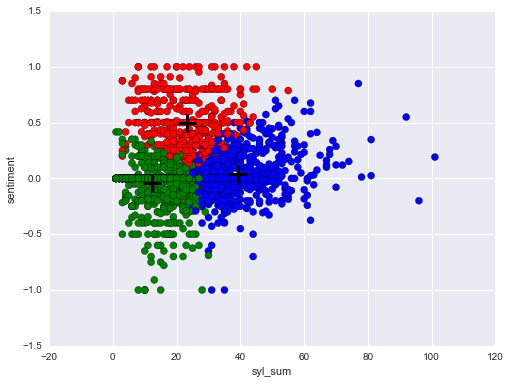

In [104]:
# scatter plot of calories versus alcohol, colored by cluster (0=red, 1=green, 2=blue)
plt.scatter(df2.syl_sum, df2.sentiment, c=colors[df2.cluster], s=50)

# cluster centers, marked by "+"
plt.scatter(centers.syl_sum, centers.sentiment, linewidths=3, marker='+', s=300, c='black')

# add labels
plt.xlabel('syl_sum')
plt.ylabel('sentiment')

In [105]:
# calculate SC for K=3
from sklearn import metrics
metrics.silhouette_score(X_scaled, km.labels_)

0.31883802584294524

In [106]:
k_range = range(2, 50)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X_scaled)
    scores.append(metrics.silhouette_score(X_scaled, km.labels_))

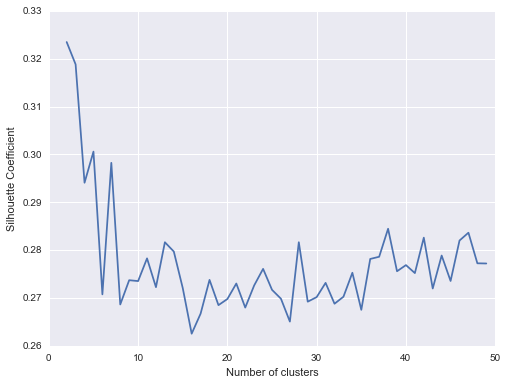

In [107]:
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

In [108]:
k_range = range(2, 75)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X_scaled)
    scores.append(metrics.silhouette_score(X_scaled, km.labels_))

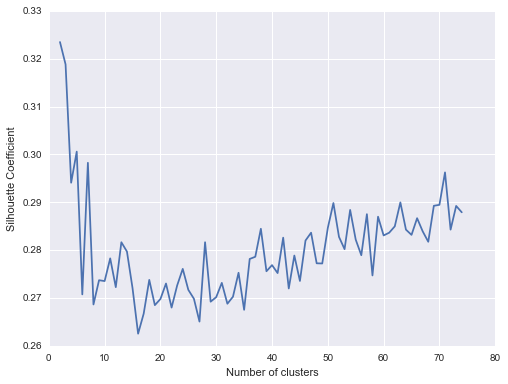

In [109]:
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

In [110]:
k_range = range(2, 125)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X_scaled)
    scores.append(metrics.silhouette_score(X_scaled, km.labels_))

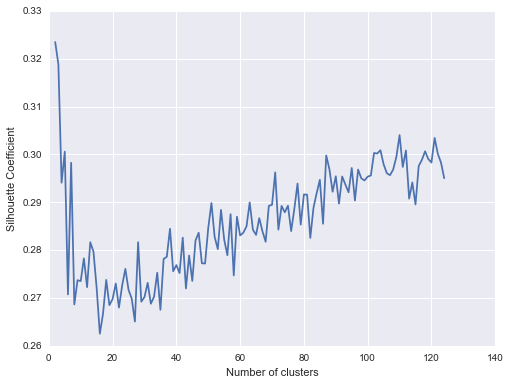

In [111]:
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

In [112]:
df2.head()

,0,char_length,syl_sum,sentiment,syl_ratio,cluster
0,The Wonderful Wizard of Oz by...,55,17,1.0,0.309091,0
1,The Cyclone 2.,11,3,0.0,0.272727,1
2,The Council with the Munchkins 3.,27,7,0.0,0.259259,1
3,How Dorothy Saved the Scarecrow 4.,28,9,0.0,0.321429,1
4,The Road Through the Forest 5.,24,6,0.0,0.250000,1


In [113]:
df3 = df2.drop('cluster', 1)


In [114]:
df3.head()

,0,char_length,syl_sum,sentiment,syl_ratio
0,The Wonderful Wizard of Oz by...,55,17,1.0,0.309091
1,The Cyclone 2.,11,3,0.0,0.272727
2,The Council with the Munchkins 3.,27,7,0.0,0.259259
3,How Dorothy Saved the Scarecrow 4.,28,9,0.0,0.321429
4,The Road Through the Forest 5.,24,6,0.0,0.250000


In [133]:
km = KMeans(n_clusters=10, random_state=1)
km.fit(X_scaled)
df2['cluster'] = km.labels_
df2.sort_values('cluster')

,0,char_length,syl_sum,sentiment,syl_ratio,cluster
437,She saw there was not much bread left in the b...,148,48,-0.033333,0.324324,0
1515,She had all the Winged Monkeys brought before ...,149,40,0.250000,0.268456,0
506,So the old woman went to the Wicked Witch of t...,99,31,-0.016667,0.313131,0
505,But the girl lived with an old woman who did n...,134,42,-0.075000,0.313433,0
500,"So, while they were walking through the forest...",150,45,-0.077778,0.300000,0
1525,As the Monkey King finished his story Dorothy ...,100,32,-0.135185,0.320000,0
1527,The strange creatures set the travelers down c...,135,44,-0.076389,0.325926,0
1035,"Therefore, as you must remain in the Palace fo...",113,36,0.000000,0.318584,0
1554,The soldier had the news carried straight to O...,131,41,-0.031250,0.312977,0
485,Dorothy was thinking so earnestly as they walk...,129,41,0.000000,0.317829,0


In [134]:
df2.groupby('cluster').mean()

,char_length,syl_sum,sentiment,syl_ratio
cluster,,,,
0,121.459375,37.159375,-0.029112,0.306758
1,74.850467,23.030374,-0.007112,0.308199
2,23.535714,9.116071,0.019354,0.395106
3,54.788079,17.390728,0.707107,0.321123
4,29.662614,8.109422,0.000320,0.273431
5,31.262211,10.390746,0.014391,0.331259
6,56.355263,18.381579,-0.539875,0.328945
7,95.240000,30.840000,0.372484,0.325069
8,181.000000,56.259259,0.180114,0.312124


In [138]:
colors = np.array(['#4d4d4d', '#0000b2', '#8833ff', '#a71d67', '#4412b2', '#808080', '#33a3ff', '#124cb2', '#f67743', '#f643c3' ])

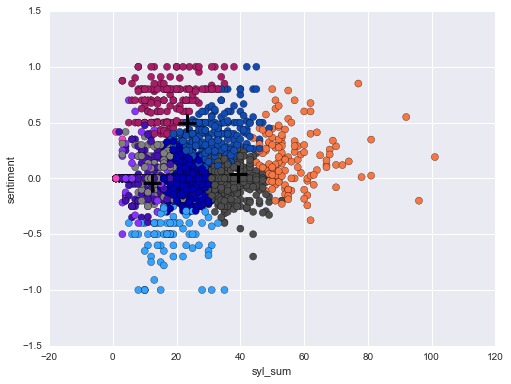

In [139]:
# scatter plot of calories versus alcohol, colored by cluster (0=red, 1=green, 2=blue)
plt.scatter(df2.syl_sum, df2.sentiment, c=colors[df2.cluster], s=50)

# cluster centers, marked by "+"
plt.scatter(centers.syl_sum, centers.sentiment, linewidths=3, marker='+', s=300, c='black')

# add labels
plt.xlabel('syl_sum')
plt.ylabel('sentiment')

In [ ]:
#take out syl_ratio
#see how many are in each section